<a href="https://colab.research.google.com/github/tisserapac/ML_Project_2022/blob/main/AlexNet_CIFAR_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Name : Anjana Tissera

##Stident ID : st123459

# AlexNet for CIFAR-10 Dataset - Version 1
- The primary goal of this experiment was to train and evaluate PyTorch's AlexNet model architecture available at torchvision.models.alexnet on the CIFAR-10 dataset.

#1. Setup the environment

In [32]:
#Import the necessary packages
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import models
from torchvision.models import AlexNet_Weights
from torchvision import transforms
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import shutil
import torch
import time
import os

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 20 14:11:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    49W / 400W |   3288MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [55]:
#Specify ImageNet mean and standard deviation and image size
MEAN = [0.49139968, 0.48215827 ,0.44653124]
STD = [0.24703233, 0.24348505, 0.26158768]
IMAGE_SIZE = 224

# determine the device to be used for training and evaluation
DEVICE = get_default_device()

DS_PATH = '/content/drive/MyDrive/RTML2023/dataset'

# specify training hyperparameters
BATCH_SIZE = 64
PRED_BATCH_SIZE = 64
EPOCHS = 100
LR = 0.001
MOMENTUM = 0.9

NUM_CLASSES = 10

LOSS_PLOT_PATH = '/content/drive/MyDrive/RTML2023/plots/AlexNet_CIFAR_ver1_Loss.png'
ACC_PLOT_PATH = '/content/drive/MyDrive/RTML2023/plots/AlexNet_CIFAR_ver1_Acc.png'
MODEL_PATH = '/content/drive/MyDrive/RTML2023/models/AlexNet_CIFAR_ver1.pth'
HISTORY_PATH = '/content/drive/MyDrive/RTML2023/history/AlexNet_CIFAR_ver1.pt'
STATE_PATH = '/content/drive/MyDrive/RTML2023/state/AlexNet_CIFAR_ver1.pt'

#2. Transforms

In [38]:
# Transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

#3. Dataloaders

In [39]:
# Datasets
train_dataset = datasets.CIFAR10(root=DS_PATH, train=True,
                                             download=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = datasets.CIFAR10(root=DS_PATH, train=False,
                                            download=True, transform=transform)

# Dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                              shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/RTML2023/dataset/cifar-10-python.tar.gz to /content/drive/MyDrive/RTML2023/dataset
Files already downloaded and verified


#4. AlexNet Model
- 

## 4.1 Initializations

In [42]:
# Create model
model = models.alexnet(weights=None)

for param in model.parameters():
	param.requires_grad = True

model.classifier[6] = nn.Linear(in_features=4096, out_features=NUM_CLASSES)

# set device
model = model.to(DEVICE)

# calculate steps per epoch for training and validation set
trainSteps = len(train_dataset) // BATCH_SIZE
valSteps = len(val_dataset) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
H_batch = {"batch_train_loss": []}

In [43]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 4.2 Training

In [44]:
# initialize loss function and optimizer
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [45]:
# loop over epochs
print("Training the network...")
startTime = time.time()
for e in tqdm(range(EPOCHS)):
    # set the model in training mode
    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    old_avgValLoss = float("Inf")

    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(train_dataloader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
        H_batch["batch_train_loss"].append(loss.cpu().detach().numpy())   
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x, y) in val_dataloader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)

            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    if avgValLoss < old_avgValLoss:
      # save model state
      model_state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
      }
      torch.save(model_state, STATE_PATH)
      old_avgValLoss = avgValLoss

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(train_dataset)
    valCorrect = valCorrect / len(val_dataset)

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    # print the model training and validation information
    print("EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))

# display the total time needed to perform the training
endTime = time.time()
training_time = endTime - startTime
print("Total time taken to train the model: {:.2f}s".format(training_time))


Training the network...


  1%|          | 1/100 [00:45<1:14:30, 45.16s/it]

EPOCH: 1/100
Train loss: 2.301416, Train accuracy: 0.1091
Val loss: 2.312643, Val accuracy: 0.1004


  2%|▏         | 2/100 [01:29<1:13:08, 44.78s/it]

EPOCH: 2/100
Train loss: 2.208048, Train accuracy: 0.1575
Val loss: 1.983002, Val accuracy: 0.2893


  3%|▎         | 3/100 [02:14<1:12:30, 44.85s/it]

EPOCH: 3/100
Train loss: 1.842398, Train accuracy: 0.3235
Val loss: 1.733970, Val accuracy: 0.3671


  4%|▍         | 4/100 [02:59<1:11:44, 44.84s/it]

EPOCH: 4/100
Train loss: 1.646040, Train accuracy: 0.3932
Val loss: 1.615554, Val accuracy: 0.4039


  5%|▌         | 5/100 [03:44<1:11:12, 44.98s/it]

EPOCH: 5/100
Train loss: 1.526752, Train accuracy: 0.4410
Val loss: 1.447977, Val accuracy: 0.4729


  6%|▌         | 6/100 [04:29<1:10:35, 45.06s/it]

EPOCH: 6/100
Train loss: 1.427086, Train accuracy: 0.4803
Val loss: 1.485503, Val accuracy: 0.4644


  7%|▋         | 7/100 [05:15<1:10:00, 45.17s/it]

EPOCH: 7/100
Train loss: 1.343504, Train accuracy: 0.5177
Val loss: 1.318880, Val accuracy: 0.5303


  8%|▊         | 8/100 [06:00<1:09:08, 45.09s/it]

EPOCH: 8/100
Train loss: 1.266265, Train accuracy: 0.5473
Val loss: 1.241635, Val accuracy: 0.5543


  9%|▉         | 9/100 [06:45<1:08:26, 45.12s/it]

EPOCH: 9/100
Train loss: 1.178678, Train accuracy: 0.5803
Val loss: 1.130861, Val accuracy: 0.6020


 10%|█         | 10/100 [07:30<1:07:43, 45.15s/it]

EPOCH: 10/100
Train loss: 1.108219, Train accuracy: 0.6083
Val loss: 1.077060, Val accuracy: 0.6215


 11%|█         | 11/100 [08:15<1:07:02, 45.19s/it]

EPOCH: 11/100
Train loss: 1.040153, Train accuracy: 0.6338
Val loss: 1.047933, Val accuracy: 0.6390


 12%|█▏        | 12/100 [09:01<1:06:19, 45.23s/it]

EPOCH: 12/100
Train loss: 0.975140, Train accuracy: 0.6572
Val loss: 0.940700, Val accuracy: 0.6716


 13%|█▎        | 13/100 [09:46<1:05:46, 45.36s/it]

EPOCH: 13/100
Train loss: 0.916547, Train accuracy: 0.6812
Val loss: 0.887368, Val accuracy: 0.6919


 14%|█▍        | 14/100 [10:32<1:05:02, 45.38s/it]

EPOCH: 14/100
Train loss: 0.860085, Train accuracy: 0.6970
Val loss: 0.887956, Val accuracy: 0.6953


 15%|█▌        | 15/100 [11:17<1:04:04, 45.23s/it]

EPOCH: 15/100
Train loss: 0.811434, Train accuracy: 0.7177
Val loss: 0.808587, Val accuracy: 0.7201


 16%|█▌        | 16/100 [12:02<1:03:19, 45.23s/it]

EPOCH: 16/100
Train loss: 0.767858, Train accuracy: 0.7300
Val loss: 0.776770, Val accuracy: 0.7291


 17%|█▋        | 17/100 [12:47<1:02:22, 45.09s/it]

EPOCH: 17/100
Train loss: 0.721345, Train accuracy: 0.7479
Val loss: 0.738223, Val accuracy: 0.7452


 18%|█▊        | 18/100 [13:32<1:01:39, 45.12s/it]

EPOCH: 18/100
Train loss: 0.680208, Train accuracy: 0.7607
Val loss: 0.735778, Val accuracy: 0.7493


 19%|█▉        | 19/100 [14:17<1:00:51, 45.08s/it]

EPOCH: 19/100
Train loss: 0.637888, Train accuracy: 0.7762
Val loss: 0.717068, Val accuracy: 0.7551


 20%|██        | 20/100 [15:02<1:00:03, 45.04s/it]

EPOCH: 20/100
Train loss: 0.600681, Train accuracy: 0.7896
Val loss: 0.665715, Val accuracy: 0.7694


 21%|██        | 21/100 [15:47<59:13, 44.98s/it]  

EPOCH: 21/100
Train loss: 0.570881, Train accuracy: 0.7999
Val loss: 0.639276, Val accuracy: 0.7823


 22%|██▏       | 22/100 [16:32<58:27, 44.97s/it]

EPOCH: 22/100
Train loss: 0.542297, Train accuracy: 0.8112
Val loss: 0.671630, Val accuracy: 0.7811


 23%|██▎       | 23/100 [17:17<57:44, 44.99s/it]

EPOCH: 23/100
Train loss: 0.512712, Train accuracy: 0.8190
Val loss: 0.658078, Val accuracy: 0.7809


 24%|██▍       | 24/100 [18:02<56:58, 44.98s/it]

EPOCH: 24/100
Train loss: 0.478520, Train accuracy: 0.8308
Val loss: 0.700667, Val accuracy: 0.7768


 25%|██▌       | 25/100 [18:47<56:23, 45.11s/it]

EPOCH: 25/100
Train loss: 0.454006, Train accuracy: 0.8391
Val loss: 0.615076, Val accuracy: 0.7952


 26%|██▌       | 26/100 [19:32<55:26, 44.95s/it]

EPOCH: 26/100
Train loss: 0.429385, Train accuracy: 0.8487
Val loss: 0.611777, Val accuracy: 0.8011


 27%|██▋       | 27/100 [20:16<54:40, 44.93s/it]

EPOCH: 27/100
Train loss: 0.401654, Train accuracy: 0.8580
Val loss: 0.592133, Val accuracy: 0.8064


 28%|██▊       | 28/100 [21:02<53:59, 45.00s/it]

EPOCH: 28/100
Train loss: 0.373143, Train accuracy: 0.8678
Val loss: 0.580421, Val accuracy: 0.8060


 29%|██▉       | 29/100 [21:47<53:14, 45.00s/it]

EPOCH: 29/100
Train loss: 0.349597, Train accuracy: 0.8771
Val loss: 0.646131, Val accuracy: 0.8001


 30%|███       | 30/100 [22:31<52:25, 44.93s/it]

EPOCH: 30/100
Train loss: 0.328223, Train accuracy: 0.8845
Val loss: 0.603733, Val accuracy: 0.8054


 31%|███       | 31/100 [23:16<51:40, 44.94s/it]

EPOCH: 31/100
Train loss: 0.301993, Train accuracy: 0.8925
Val loss: 0.610869, Val accuracy: 0.8071


 32%|███▏      | 32/100 [24:01<50:57, 44.96s/it]

EPOCH: 32/100
Train loss: 0.285332, Train accuracy: 0.8992
Val loss: 0.611026, Val accuracy: 0.8102


 33%|███▎      | 33/100 [24:46<50:14, 44.99s/it]

EPOCH: 33/100
Train loss: 0.260987, Train accuracy: 0.9078
Val loss: 0.589485, Val accuracy: 0.8155


 34%|███▍      | 34/100 [25:32<49:35, 45.08s/it]

EPOCH: 34/100
Train loss: 0.245491, Train accuracy: 0.9120
Val loss: 0.589654, Val accuracy: 0.8204


 35%|███▌      | 35/100 [26:16<48:44, 45.00s/it]

EPOCH: 35/100
Train loss: 0.227793, Train accuracy: 0.9182
Val loss: 0.603041, Val accuracy: 0.8152


 36%|███▌      | 36/100 [27:01<47:59, 44.99s/it]

EPOCH: 36/100
Train loss: 0.209207, Train accuracy: 0.9247
Val loss: 0.604176, Val accuracy: 0.8174


 37%|███▋      | 37/100 [27:47<47:21, 45.11s/it]

EPOCH: 37/100
Train loss: 0.198277, Train accuracy: 0.9292
Val loss: 0.610414, Val accuracy: 0.8189


 38%|███▊      | 38/100 [28:32<46:40, 45.16s/it]

EPOCH: 38/100
Train loss: 0.177508, Train accuracy: 0.9372
Val loss: 0.652145, Val accuracy: 0.8147


 39%|███▉      | 39/100 [29:18<45:58, 45.22s/it]

EPOCH: 39/100
Train loss: 0.164764, Train accuracy: 0.9417
Val loss: 0.627969, Val accuracy: 0.8197


 40%|████      | 40/100 [30:03<45:11, 45.18s/it]

EPOCH: 40/100
Train loss: 0.151679, Train accuracy: 0.9456
Val loss: 0.673303, Val accuracy: 0.8132


 41%|████      | 41/100 [30:48<44:23, 45.14s/it]

EPOCH: 41/100
Train loss: 0.143712, Train accuracy: 0.9490
Val loss: 0.634743, Val accuracy: 0.8242


 42%|████▏     | 42/100 [31:33<43:34, 45.07s/it]

EPOCH: 42/100
Train loss: 0.134467, Train accuracy: 0.9526
Val loss: 0.662584, Val accuracy: 0.8203


 43%|████▎     | 43/100 [32:18<42:50, 45.09s/it]

EPOCH: 43/100
Train loss: 0.125035, Train accuracy: 0.9565
Val loss: 0.668187, Val accuracy: 0.8227


 44%|████▍     | 44/100 [33:03<42:03, 45.07s/it]

EPOCH: 44/100
Train loss: 0.115245, Train accuracy: 0.9580
Val loss: 0.666464, Val accuracy: 0.8270


 45%|████▌     | 45/100 [33:48<41:24, 45.17s/it]

EPOCH: 45/100
Train loss: 0.107650, Train accuracy: 0.9620
Val loss: 0.703542, Val accuracy: 0.8187


 46%|████▌     | 46/100 [34:34<40:43, 45.25s/it]

EPOCH: 46/100
Train loss: 0.099537, Train accuracy: 0.9651
Val loss: 0.685278, Val accuracy: 0.8207


 47%|████▋     | 47/100 [35:19<40:01, 45.31s/it]

EPOCH: 47/100
Train loss: 0.095233, Train accuracy: 0.9667
Val loss: 0.712661, Val accuracy: 0.8152


 48%|████▊     | 48/100 [36:04<39:18, 45.36s/it]

EPOCH: 48/100
Train loss: 0.091313, Train accuracy: 0.9683
Val loss: 0.671822, Val accuracy: 0.8253


 49%|████▉     | 49/100 [36:49<38:28, 45.26s/it]

EPOCH: 49/100
Train loss: 0.087929, Train accuracy: 0.9700
Val loss: 0.682734, Val accuracy: 0.8257


 50%|█████     | 50/100 [37:35<37:42, 45.25s/it]

EPOCH: 50/100
Train loss: 0.080018, Train accuracy: 0.9718
Val loss: 0.734624, Val accuracy: 0.8235


 51%|█████     | 51/100 [38:20<36:56, 45.23s/it]

EPOCH: 51/100
Train loss: 0.077514, Train accuracy: 0.9734
Val loss: 0.754124, Val accuracy: 0.8205


 52%|█████▏    | 52/100 [39:05<36:10, 45.21s/it]

EPOCH: 52/100
Train loss: 0.070702, Train accuracy: 0.9750
Val loss: 0.754542, Val accuracy: 0.8232


 53%|█████▎    | 53/100 [39:51<35:29, 45.30s/it]

EPOCH: 53/100
Train loss: 0.068742, Train accuracy: 0.9759
Val loss: 0.705899, Val accuracy: 0.8274


 54%|█████▍    | 54/100 [40:36<34:42, 45.27s/it]

EPOCH: 54/100
Train loss: 0.061737, Train accuracy: 0.9790
Val loss: 0.728606, Val accuracy: 0.8255


 55%|█████▌    | 55/100 [41:21<33:53, 45.20s/it]

EPOCH: 55/100
Train loss: 0.064953, Train accuracy: 0.9770
Val loss: 0.747311, Val accuracy: 0.8255


 56%|█████▌    | 56/100 [42:06<33:11, 45.27s/it]

EPOCH: 56/100
Train loss: 0.056053, Train accuracy: 0.9817
Val loss: 0.771360, Val accuracy: 0.8279


 57%|█████▋    | 57/100 [42:52<32:30, 45.36s/it]

EPOCH: 57/100
Train loss: 0.051381, Train accuracy: 0.9822
Val loss: 0.726892, Val accuracy: 0.8307


 58%|█████▊    | 58/100 [43:37<31:45, 45.38s/it]

EPOCH: 58/100
Train loss: 0.051365, Train accuracy: 0.9827
Val loss: 0.717372, Val accuracy: 0.8332


 59%|█████▉    | 59/100 [44:23<31:03, 45.46s/it]

EPOCH: 59/100
Train loss: 0.049827, Train accuracy: 0.9829
Val loss: 0.745299, Val accuracy: 0.8272


 60%|██████    | 60/100 [45:08<30:15, 45.39s/it]

EPOCH: 60/100
Train loss: 0.050004, Train accuracy: 0.9828
Val loss: 0.747128, Val accuracy: 0.8296


 61%|██████    | 61/100 [45:53<29:27, 45.32s/it]

EPOCH: 61/100
Train loss: 0.051449, Train accuracy: 0.9825
Val loss: 0.750879, Val accuracy: 0.8278


 62%|██████▏   | 62/100 [46:39<28:45, 45.41s/it]

EPOCH: 62/100
Train loss: 0.045913, Train accuracy: 0.9848
Val loss: 0.769934, Val accuracy: 0.8289


 63%|██████▎   | 63/100 [47:24<28:00, 45.41s/it]

EPOCH: 63/100
Train loss: 0.043295, Train accuracy: 0.9857
Val loss: 0.836467, Val accuracy: 0.8242


 64%|██████▍   | 64/100 [48:09<27:06, 45.19s/it]

EPOCH: 64/100
Train loss: 0.040221, Train accuracy: 0.9860
Val loss: 0.809668, Val accuracy: 0.8308


 65%|██████▌   | 65/100 [48:54<26:20, 45.16s/it]

EPOCH: 65/100
Train loss: 0.040377, Train accuracy: 0.9862
Val loss: 0.762326, Val accuracy: 0.8325


 66%|██████▌   | 66/100 [49:39<25:35, 45.17s/it]

EPOCH: 66/100
Train loss: 0.040763, Train accuracy: 0.9866
Val loss: 0.782988, Val accuracy: 0.8266


 67%|██████▋   | 67/100 [50:25<24:52, 45.23s/it]

EPOCH: 67/100
Train loss: 0.037962, Train accuracy: 0.9869
Val loss: 0.784463, Val accuracy: 0.8285


 68%|██████▊   | 68/100 [51:10<24:06, 45.21s/it]

EPOCH: 68/100
Train loss: 0.040275, Train accuracy: 0.9863
Val loss: 0.757664, Val accuracy: 0.8291


 69%|██████▉   | 69/100 [51:55<23:24, 45.31s/it]

EPOCH: 69/100
Train loss: 0.039060, Train accuracy: 0.9873
Val loss: 0.763156, Val accuracy: 0.8355


 70%|███████   | 70/100 [52:41<22:40, 45.35s/it]

EPOCH: 70/100
Train loss: 0.032513, Train accuracy: 0.9895
Val loss: 0.805699, Val accuracy: 0.8293


 71%|███████   | 71/100 [53:26<21:52, 45.24s/it]

EPOCH: 71/100
Train loss: 0.031249, Train accuracy: 0.9895
Val loss: 0.806551, Val accuracy: 0.8308


 72%|███████▏  | 72/100 [54:11<21:10, 45.37s/it]

EPOCH: 72/100
Train loss: 0.032589, Train accuracy: 0.9887
Val loss: 0.807986, Val accuracy: 0.8307


 73%|███████▎  | 73/100 [54:57<20:25, 45.37s/it]

EPOCH: 73/100
Train loss: 0.030426, Train accuracy: 0.9901
Val loss: 0.843902, Val accuracy: 0.8295


 74%|███████▍  | 74/100 [55:42<19:36, 45.26s/it]

EPOCH: 74/100
Train loss: 0.031833, Train accuracy: 0.9894
Val loss: 0.805688, Val accuracy: 0.8323


 75%|███████▌  | 75/100 [56:27<18:49, 45.18s/it]

EPOCH: 75/100
Train loss: 0.030950, Train accuracy: 0.9891
Val loss: 0.813723, Val accuracy: 0.8287


 76%|███████▌  | 76/100 [57:12<18:04, 45.19s/it]

EPOCH: 76/100
Train loss: 0.029207, Train accuracy: 0.9903
Val loss: 0.808061, Val accuracy: 0.8339


 77%|███████▋  | 77/100 [57:57<17:20, 45.26s/it]

EPOCH: 77/100
Train loss: 0.030549, Train accuracy: 0.9900
Val loss: 0.804568, Val accuracy: 0.8354


 78%|███████▊  | 78/100 [58:43<16:37, 45.35s/it]

EPOCH: 78/100
Train loss: 0.029609, Train accuracy: 0.9901
Val loss: 0.842866, Val accuracy: 0.8311


 79%|███████▉  | 79/100 [59:28<15:50, 45.26s/it]

EPOCH: 79/100
Train loss: 0.027036, Train accuracy: 0.9908
Val loss: 0.800733, Val accuracy: 0.8322


 80%|████████  | 80/100 [1:00:14<15:06, 45.35s/it]

EPOCH: 80/100
Train loss: 0.026462, Train accuracy: 0.9913
Val loss: 0.850373, Val accuracy: 0.8339


 81%|████████  | 81/100 [1:00:59<14:21, 45.36s/it]

EPOCH: 81/100
Train loss: 0.027074, Train accuracy: 0.9915
Val loss: 0.823284, Val accuracy: 0.8347


 82%|████████▏ | 82/100 [1:01:44<13:35, 45.32s/it]

EPOCH: 82/100
Train loss: 0.025701, Train accuracy: 0.9913
Val loss: 0.813016, Val accuracy: 0.8344


 83%|████████▎ | 83/100 [1:02:30<12:51, 45.37s/it]

EPOCH: 83/100
Train loss: 0.026194, Train accuracy: 0.9913
Val loss: 0.779543, Val accuracy: 0.8377


 84%|████████▍ | 84/100 [1:03:15<12:05, 45.32s/it]

EPOCH: 84/100
Train loss: 0.023812, Train accuracy: 0.9918
Val loss: 0.813767, Val accuracy: 0.8344


 85%|████████▌ | 85/100 [1:04:00<11:19, 45.31s/it]

EPOCH: 85/100
Train loss: 0.022467, Train accuracy: 0.9925
Val loss: 0.815914, Val accuracy: 0.8338


 86%|████████▌ | 86/100 [1:04:45<10:32, 45.21s/it]

EPOCH: 86/100
Train loss: 0.022069, Train accuracy: 0.9923
Val loss: 0.856751, Val accuracy: 0.8334


 87%|████████▋ | 87/100 [1:05:30<09:46, 45.12s/it]

EPOCH: 87/100
Train loss: 0.016868, Train accuracy: 0.9946
Val loss: 0.876655, Val accuracy: 0.8359


 88%|████████▊ | 88/100 [1:06:15<09:01, 45.16s/it]

EPOCH: 88/100
Train loss: 0.023847, Train accuracy: 0.9920
Val loss: 0.830324, Val accuracy: 0.8348


 89%|████████▉ | 89/100 [1:07:01<08:17, 45.20s/it]

EPOCH: 89/100
Train loss: 0.023659, Train accuracy: 0.9921
Val loss: 0.846143, Val accuracy: 0.8329


 90%|█████████ | 90/100 [1:07:46<07:31, 45.17s/it]

EPOCH: 90/100
Train loss: 0.018799, Train accuracy: 0.9935
Val loss: 0.884381, Val accuracy: 0.8312


 91%|█████████ | 91/100 [1:08:30<06:45, 45.05s/it]

EPOCH: 91/100
Train loss: 0.022320, Train accuracy: 0.9924
Val loss: 0.815723, Val accuracy: 0.8370


 92%|█████████▏| 92/100 [1:09:15<06:00, 45.01s/it]

EPOCH: 92/100
Train loss: 0.019959, Train accuracy: 0.9930
Val loss: 0.835812, Val accuracy: 0.8368


 93%|█████████▎| 93/100 [1:10:01<05:15, 45.07s/it]

EPOCH: 93/100
Train loss: 0.020712, Train accuracy: 0.9932
Val loss: 0.858854, Val accuracy: 0.8359


 94%|█████████▍| 94/100 [1:10:45<04:30, 45.01s/it]

EPOCH: 94/100
Train loss: 0.018895, Train accuracy: 0.9939
Val loss: 0.812221, Val accuracy: 0.8357


 95%|█████████▌| 95/100 [1:11:30<03:44, 44.97s/it]

EPOCH: 95/100
Train loss: 0.018844, Train accuracy: 0.9939
Val loss: 0.878305, Val accuracy: 0.8364


 96%|█████████▌| 96/100 [1:12:15<02:59, 44.97s/it]

EPOCH: 96/100
Train loss: 0.017592, Train accuracy: 0.9944
Val loss: 0.846086, Val accuracy: 0.8378


 97%|█████████▋| 97/100 [1:13:00<02:14, 44.98s/it]

EPOCH: 97/100
Train loss: 0.020387, Train accuracy: 0.9935
Val loss: 0.867148, Val accuracy: 0.8338


 98%|█████████▊| 98/100 [1:13:46<01:30, 45.14s/it]

EPOCH: 98/100
Train loss: 0.017013, Train accuracy: 0.9947
Val loss: 0.851867, Val accuracy: 0.8349


 99%|█████████▉| 99/100 [1:14:31<00:45, 45.20s/it]

EPOCH: 99/100
Train loss: 0.016387, Train accuracy: 0.9948
Val loss: 0.896257, Val accuracy: 0.8317


100%|██████████| 100/100 [1:15:16<00:00, 45.16s/it]

EPOCH: 100/100
Train loss: 0.017075, Train accuracy: 0.9944
Val loss: 0.842777, Val accuracy: 0.8338
Total time taken to train the model: 4516.36s


In [46]:
# serialize the model to disk
torch.save(model, MODEL_PATH)

In [47]:
# serialize the history to disk
saveObject = {
    'train_losses': H_batch["batch_train_loss"],
    'avg_train_losses_per_epoch': H["train_loss"],
    'avg_val_losses_per_epoch': H["val_loss"],
    'avg_train_accs_per_epoch': H["train_acc"],
    'avg_val_accs_per_epoch': H["val_acc"],
    'training_time': training_time
}

torch.save(saveObject, HISTORY_PATH)

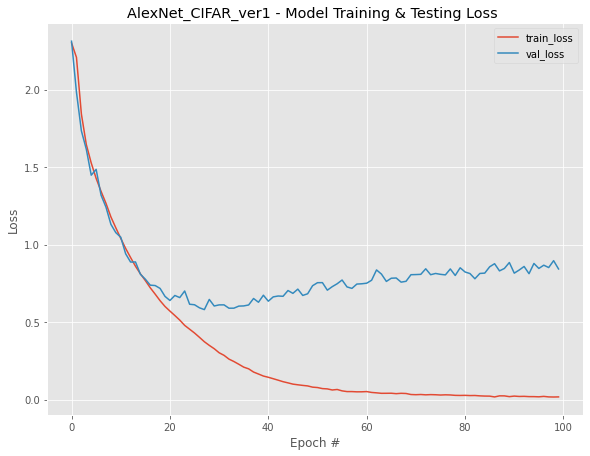

In [51]:
# plot the training and testing loss
plt.style.use("ggplot")
plt.figure(figsize=(9.6,7.2))
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("AlexNet_CIFAR_ver1 - Model Training & Testing Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(LOSS_PLOT_PATH)

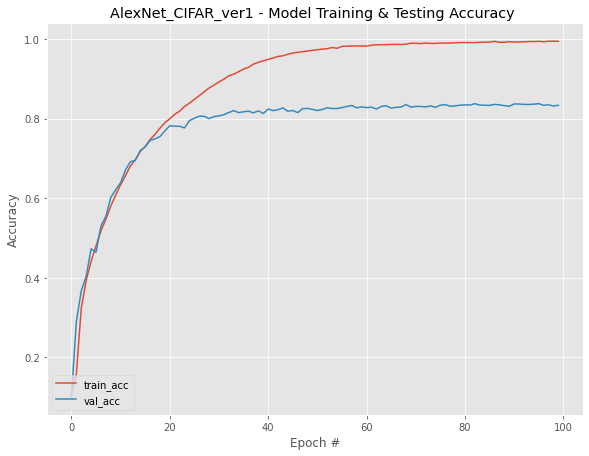

In [50]:
# plot the training and testing ccuracy
plt.style.use("ggplot")
plt.figure(figsize=(9.6,7.2))
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("AlexNet_CIFAR_ver1 - Model Training & Testing Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(ACC_PLOT_PATH)

#5. Test Set Accuracy

In [56]:
testSteps = len(test_dataset) // PRED_BATCH_SIZE
testCorrect = 0

with torch.no_grad():
      # set the model in evaluation mode
      model.eval()

      totalTestlCorrect = 0

      # loop over the test set
      for (x, y) in test_dataloader:
          # send the input to the device
          (x, y) = (x.to(DEVICE), y.to(DEVICE))

          # make the predictions
          pred = model(x)

          # calculate the number of correct predictions
          testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

# calculate the test accuracy
testCorrect = testCorrect / len(test_dataset)

In [57]:
print('Test accuracy: ', testCorrect)

Test accuracy:  0.8371


In [58]:
def count_parameters(model):
  params = [p.numel() for p in model.parameters() if p.requires_grad]
  for item in params:
      print(f'{item:>6}')
  print(f'______\n{sum(params):>6}')

count_parameters(model)

 23232
    64
307200
   192
663552
   384
884736
   256
589824
   256
37748736
  4096
16777216
  4096
 40960
    10
______
57044810


# Discussion
## Introduction
In this lab exercise, I trained and evaluate the PyTorch AlexNet model (torchvision.models.alexnet) on the CIFAR-10 dataset

## Background
AlexNet is a deep convolutional neural network (CNN) that was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton in 2012. It was the first CNN to win the ImageNet Large Scale Visual Recognition Challenge (ILSVRC). The 2012 AlexNet version was trained on a dataset of over 1.2 million images and achieved a top-5 error rate of 15.3%.

The network consists of 8 layers, including 5 convolutional layers and 3 fully connected layers. The convolutional layers are used to extract features from the input images, while the fully connected layers are used to classify the images based on those features. The network also uses pooling layers to reduce the spatial resolution of the feature maps and rectified linear units (ReLU) as the activation function.

Some of the key features of Alexnet are:
*   Use of ReLU activation function: AlexNet utilizes the ReLU activation function, which has been found to improve the performance of deep neural networks.

*   Local Response Normalization (LRN): AlexNet uses LRN to normalize the activations of neurons within a local region, which helps to reduce overfitting.

*   Dropout regularization: AlexNet uses dropout to prevent overfitting by randomly dropping out neurons during training.

*   Split into multiple GPUs: AlexNet was designed to be trained on multiple GPUs, allowing for faster training times.

*   Overlapping pooling: AlexNet uses overlapping pooling, which has been found to improve the performance of CNNs on image classification tasks.

The success of AlexNet led to an increased interest in deep CNNs and their application in computer vision tasks.

[Ref: [ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)]

## Goal
The primary goal of this experiment was to train and evaluate PyTorch's  AlexNet model architecture available at torchvision.models.alexnet on the CIFAR-10 dataset. This implementation is based on the paper "[One weird trick for parallelizing convolutional neural networks](https://arxiv.org/abs/1404.5997)" rather than the original publication referenced above.

## Method

Method followed in this experiment is outlined in the following steps.

**Step 1**: Define the data transformations.
*   The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
[Ref: [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)]
*   To be as close as to the data preprocessing performed by the AlexNet inventors, in this exercise, I resize the 32x32 images to 256x256, obtain a center crop of size 224. The resulting image was then transformed to a Tensor which will convert the images in PIL Images of the dataset in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. Finally, the resulting Tensors are normalized using mean and the standard deviation values over the three channels (R, G, B) for the CIFAR-10 dataset(mean:[0.4914, 0.4822, 0.4465], std:[0.2470, 0.2435, 0.2616]).
*   These same data transformations were applied to the images in the training, validation, and testing datasets.


**Step 2**: Prepare the dataloaders
*   In this step I downloaded the training and testing datasets for CIFAR-10. The 50000 images in the training dataset is again split into 40000 and 10000 as the training and validation datasets.

**Step 3**: Initialize the model
*   In this step I initialized the AlexNet implementation provided in torchvision module as `torchvision.models.alexnet(weights=None)`. 

*   I selected the `weights=None` since the goal of this experiment was to train AlexNet weights for the CIFAR-10 dataset. 

*   Further, for all the model parameters I set `requires_grad = True`, since I wanted to optimize the AlexNet weights from scratch.

**Step 4**: Train and evaluate the model
I trained the model for 100 epochs. CrossEntropyLoss was used as the loss function and stochastic gradient descent(SGD) was used as the optimizer with a leaning rate of 0.001, and a momentum of 0.9

While training the model state/parameters with the best validation results was serialized and saved to the disk.
 

## Results
*   Behaviour of model training and validation loss over the epochs is explained in the figure "AlexNet_CIFAR_ver1 - Model Training & Testing Loss" above. Similarly, the behavior of training and validation accuracy over the epochs is explained in the figure "AlexNet_CIFAR_ver1 - Model Training & Testing Accuracy".
*   Analyzing these two graphs we can clearly see that the model overfits after around 20 epochs.
*   After training of 100 epochs even though training accuracy reached 99.48%, the maximum validation accuracy was 83.78%. The best version of the model saved to the disk gave 83.71% accuracy on the test dataset.

## Conclusion
*   In this exercise I attempted to train and evaluate the AlexNet implementation provided in PyTorch's torchvision module from scratch. Thus no pre-trained weights were used. Further, I un-freeze all model parameters such that the parameters of all layers will get updated during model training.
*   Unfortunately the experiment resulted in model overfitting. When I analyzed the total number of parameters trained during this experiment it was 57044810. But the training dataset only had 40000 images, which is clearly not sufficient enough to train 57044810 parameters.
*   If more data transformations were used to increase the number of training samples, and instead of Adam optimizer was experimented instead of SGD serious model overfitting may have been avoided leading to better test accuracies.
